In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

2022-12-01 16:35:44.991071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 16:35:48.968078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# conv_base.summary()

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/sam.treweek/Downloads/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 500)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 833ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 932ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step


In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (500, 4 * 4 * 512))

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30


/Users/sam.treweek/Projects/flerovium/.venv/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


100/100 [==============================] - 3s 19ms/step - loss: 0.6177 - acc: 0.6640 - val_loss: 0.4511 - val_acc: 0.8210
Epoch 2/30
100/100 [==============================] - 2s 17ms/step - loss: 0.4347 - acc: 0.7950 - val_loss: 0.3629 - val_acc: 0.8640
Epoch 3/30
100/100 [==============================] - 2s 17ms/step - loss: 0.3567 - acc: 0.8410 - val_loss: 0.3276 - val_acc: 0.8580
Epoch 4/30
100/100 [==============================] - 2s 17ms/step - loss: 0.3084 - acc: 0.8765 - val_loss: 0.2966 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2848 - acc: 0.8885 - val_loss: 0.2798 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2542 - acc: 0.9010 - val_loss: 0.2700 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2344 - acc: 0.9065 - val_loss: 0.2602 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 2s 17ms/step - loss: 0.228

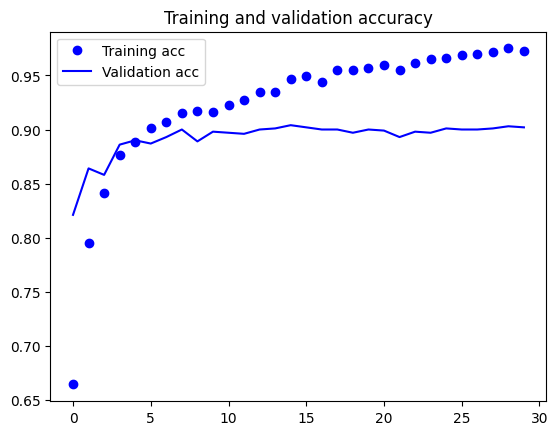

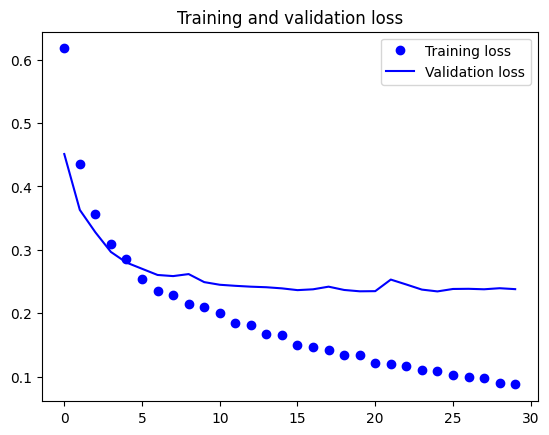

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [10]:
conv_base.trainable = False

In [11]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/Users/sam.treweek/Projects/flerovium/.venv/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/sam.treweek/Projects/flerovium/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
100/100 - 147s - loss: 0.5930 - acc: 0.6805 - val_loss: 0.4595 - val_acc: 0.8110 - 147s/epoch - 1s/step
Epoch 2/30
100/100 - 142s - loss: 0.4811 - acc: 0.7880 - val_loss: 0.3812 - val_acc: 0.8570 - 142s/epoch - 1s/step
Epoch 3/30
100/100 - 141s - loss: 0.4316 - acc: 0.8175 - val_loss: 0.3363 - val_acc: 0.8730 - 141s/epoch - 1s/step
Epoch 4/30
100/100 - 143s - loss: 0.4095 - acc: 0.8175 - val_loss: 0.3090 - val_acc: 0.8800 - 143s/epoch - 1s/step
Epoch 5/30
100/100 - 141s - loss: 0.3809 - acc: 0.8335 - val_loss: 0.2963 - val_acc: 0.8870 - 141s/epoch - 1s/step
Epoch 6/30
100/100 - 146s - loss: 0.3628 - acc: 0.8360 - val_loss: 0.2839 - val_acc: 0.8900 - 146s/epoch - 1s/step
Epoch 7/30
100/100 - 140s - loss: 0.3654 - acc: 0.8315 - val_loss: 0.2788 - val_acc: 0.8870 - 140s/epoch - 1s/step
Epoch 8/30
100/100 - 139s - loss: 0.3560 - acc: 0.8385 - val_loss: 0.2735 - val_acc: 0.8870 - 139s/epoch - 1s/step
Epoch 9/30
100/100 - 138s - loss: 0.3354 - acc: 0.8610 - val_loss: 0.2645 - val_

In [13]:
model.save('cats_and_dogs_small_3.h5')

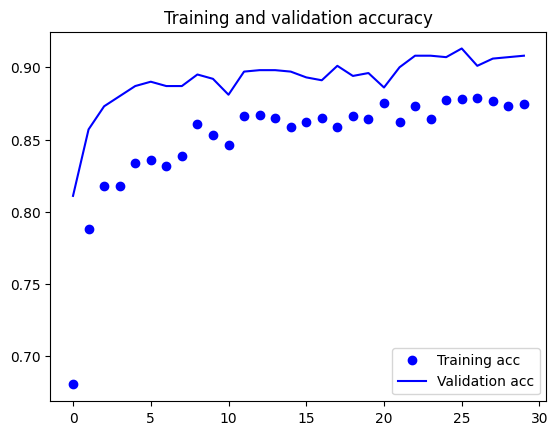

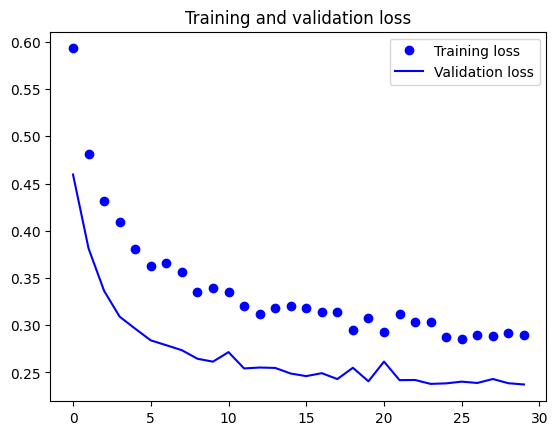

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()